In [88]:
import pandas as pd
import requests
import numpy as np

import koreanize_matplotlib
import matplotlib.pyplot as plt

BASE_URL = "https://kosis.kr/openapi/Param/statisticsParameterData.do"

params = {
    "method":"getList",
    "apiKey":"ZWRiNzEyMzEwNGI5OWQ3NzcxNGM1MDNiOGJkOTQ0Y2M=",
    "itmId":"T2+",
    "objL1":"3404+3408+3436+3531+3642+3704+",
    "objL2":"S0+",
    "objL3":"",
    "objL4":"",
    "objL5":"",
    "objL6":"",
    "objL7":"",
    "objL8":"",
    "format":"json",
    "jsonVD":"Y",
    "prdSe":"H",
    "newEstPrdCnt":"7",
    "orgId":"101",
    "tblId":"DT_1ES3A02S"
}

response = requests.get(BASE_URL, params=params)
df_raw = pd.DataFrame(response.json())

In [89]:
keep_cols = ["PRD_DE", "C1", "C1_NM", "DT"]
missing = [c for c in keep_cols if c not in df_raw.columns]
if missing:
    raise ValueError(f"employment_raw에 필요한 컬럼이 없습니다: {missing}")

emp = df_raw[keep_cols].copy()
emp.columns = ["기간", "행정코드", "지역명", "값"]

emp["행정코드"] = emp["행정코드"].astype(str)
# emp["기간"] = emp["기간"].astype(str)
emp["값"] = pd.to_numeric(emp["값"], errors="coerce")

# 2) 기간 포맷 정리
# emp["기간"] = (
#     emp["기간"]
#     .astype(str)
#     .str.strip()
#     .str[:4]
#     + "-"
#     + emp["기간"].astype(str).str[4:]
# )


pivot_df = (
    emp
    .pivot_table(
        index=["행정코드", "지역명"],
        columns="기간",
        values="값",
        aggfunc="mean"  # 동일 키 중복 시 평균(보통 중복 없어야 정상)
    )
    .reset_index()
)

pivot_df



기간,행정코드,지역명,202201,202202,202301,202302,202401,202402,202501
0,3404,아산시,196.2,204.5,208.4,211.9,221.5,225.2,231.7
1,3408,당진시,101.6,103.6,106.2,108.7,108.8,110.2,113.2
2,3436,홍성군,58.9,61.7,61.3,59.3,61.6,62.5,63.4
3,3531,완주군,52.4,55.4,58.9,60.6,60.7,60.7,61.4
4,3642,무안군,49.1,50.1,50.6,50.6,51.5,53.3,53.5
5,3704,안동시,85.4,86.8,88.1,89.2,88.7,85.7,86.9


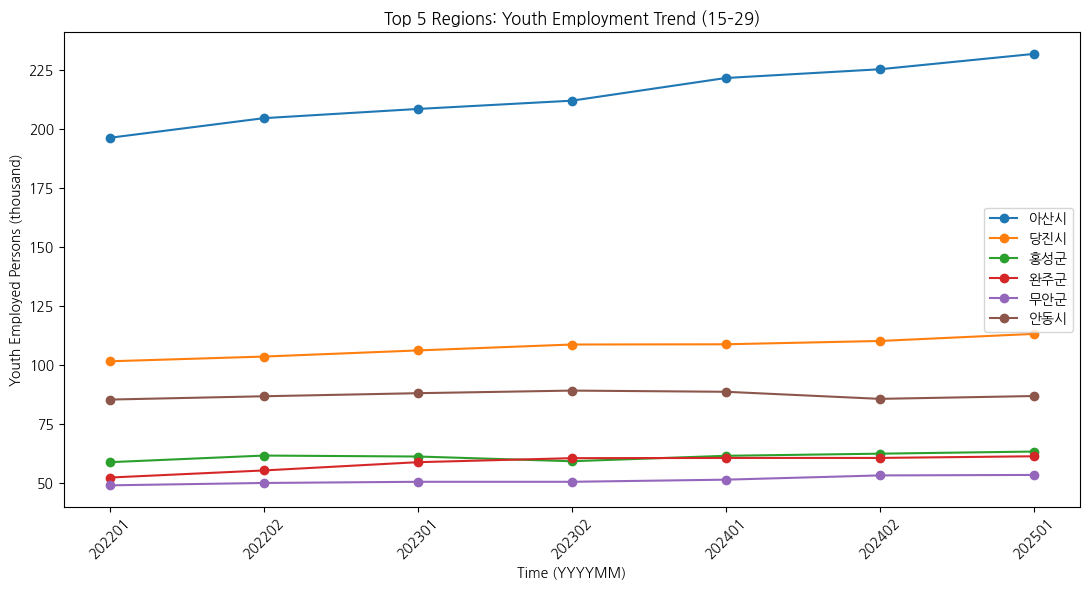

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# 기간 컬럼 자동 추출 (숫자형 YYYYMM)
# pivot_df = pivot_df.loc[~(pivot_df['지역명'] == '아산시')].copy()

time_cols = sorted([c for c in pivot_df.columns if str(c).isdigit()])

plt.figure(figsize=(11, 6))

for _, row in pivot_df.iterrows():
    y = row[time_cols].astype(float).values
    plt.plot(time_cols, y, marker="o", label=row["지역명"])

plt.xlabel("Time (YYYYMM)")
plt.ylabel("Youth Employed Persons (thousand)")
plt.title("Top 5 Regions: Youth Employment Trend (15–29)")
plt.xticks(time_cols, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



In [91]:
import pandas as pd
import requests
import numpy as np

BASE_URL = "https://kosis.kr/openapi/Param/statisticsParameterData.do"

params = {
    "method":"getList",
    "apiKey":"ZWRiNzEyMzEwNGI5OWQ3NzcxNGM1MDNiOGJkOTQ0Y2M=",
    "itmId":"T2+",
    "objL1":"3404+3408+3436+3531+3642+3704+",
    "objL2":"S0+",
    "objL3":"",
    "objL4":"",
    "objL5":"",
    "objL6":"",
    "objL7":"",
    "objL8":"",
    "format":"json",
    "jsonVD":"Y",
    "prdSe":"H",
    "newEstPrdCnt":"7",
    "orgId":"101",
    "tblId":"DT_1ES3A02S"
}

response = requests.get(BASE_URL, params=params)
df_raw = pd.DataFrame(response.json())

In [92]:
# 데이터 불러오기
import pandas as pd
import re 

pd.set_option('display.max_rows', 10000)

df = pd.read_csv(
    "../../data/202401_202401_연령별인구현황_월간.csv",
    encoding="cp949"
)

df["지역명"] = df["행정구역"].str.split("(").str[0].str.strip()
df["행정코드"] = df["행정구역"].str.extract(r"\((\d+)\)").astype("Int64")

# 3. 시/군 단위만 추출
# - 시도: code % 100_000_000 == 0
# - 시군구: code % 100_000_000 != 0 AND code % 100_000 == 0
sigungu = df[
    (df["행정코드"] % 100_000_000 != 0) &
    (df["행정코드"] % 100_000 == 0)
].copy()

# 4. 숫자 컬럼 정리
num_cols = [
    "2024년01월_계_20~24세",
    "2024년01월_계_25~29세",
    "2024년01월_계_15~19세",
]

for c in num_cols:
    sigungu[c] = (
        sigungu[c]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(int)
    )

# 5. 청년(20~34) 인구 계산
sigungu["청년(20~34)인구"] = (
    sigungu["2024년01월_계_20~24세"]
    + sigungu["2024년01월_계_25~29세"]
    + sigungu["2024년01월_계_15~19세"]
)

# 6. 검색할 지역 정의
include_regions = [
    "아산시", "무안군", 
    "안동시", "완주군", "홍성군",
    "당진시"
]

sigungu["상위지역"] = sigungu["지역명"].str.split().str[0]
pattern = "|".join(map(re.escape, include_regions))
local_sigungu = sigungu[sigungu["지역명"].str.contains(pattern)].copy()

# 7. 결과 테이블 구성
result = local_sigungu[
    ["지역명", "청년(20~34)인구"]
]

all_result = pd.DataFrame()
all_result["지역명"] = local_sigungu["지역명"].copy()
all_result[202401] = local_sigungu["청년(20~34)인구"].copy()

result

,지역명,청년(20~34)인구
187,충청남도 아산시,56088
191,충청남도 당진시,22478
196,충청남도 홍성군,13266
208,전북특별자치도 완주군,13409
232,전라남도 무안군,13824
245,경상북도 안동시,21389


In [93]:
# 데이터 불러오기
import pandas as pd
import re 

pd.set_option('display.max_rows', 10000)

df = pd.read_csv(
    "../../data/202301_202301_연령별인구현황_월간.csv",
    encoding="cp949"
)

df["지역명"] = df["행정구역"].str.split("(").str[0].str.strip()
df["행정코드"] = df["행정구역"].str.extract(r"\((\d+)\)").astype("Int64")

# 3. 시/군 단위만 추출
# - 시도: code % 100_000_000 == 0
# - 시군구: code % 100_000_000 != 0 AND code % 100_000 == 0
sigungu = df[
    (df["행정코드"] % 100_000_000 != 0) &
    (df["행정코드"] % 100_000 == 0)
].copy()

# 4. 숫자 컬럼 정리
num_cols = [
    "2023년01월_계_20~24세",
    "2023년01월_계_25~29세",
    "2023년01월_계_15~19세",
]

for c in num_cols:
    sigungu[c] = (
        sigungu[c]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(int)
    )

# 5. 청년(20~34) 인구 계산
sigungu["청년(20~34)인구"] = (
    sigungu["2023년01월_계_20~24세"]
    + sigungu["2023년01월_계_25~29세"]
    + sigungu["2023년01월_계_15~19세"]
)

# 6. 검색할 지역 정의
include_regions = [
    "아산시", "무안군", 
    "안동시", "완주군", "홍성군",
    "당진시"
]

sigungu["상위지역"] = sigungu["지역명"].str.split().str[0]
pattern = "|".join(map(re.escape, include_regions))
local_sigungu = sigungu[sigungu["지역명"].str.contains(pattern)].copy()

# 7. 결과 테이블 구성
result = local_sigungu[
    ["지역명", "청년(20~34)인구"]
]

all_result[202301] = local_sigungu["청년(20~34)인구"].tolist().copy()

In [94]:
# 데이터 불러오기
import pandas as pd
import re 

pd.set_option('display.max_rows', 10000)

df = pd.read_csv(
    "../../data/202201_202201_연령별인구현황_월간.csv",
    encoding="cp949"
)

df["지역명"] = df["행정구역"].str.split("(").str[0].str.strip()
df["행정코드"] = df["행정구역"].str.extract(r"\((\d+)\)").astype("Int64")

# 3. 시/군 단위만 추출
# - 시도: code % 100_000_000 == 0
# - 시군구: code % 100_000_000 != 0 AND code % 100_000 == 0
sigungu = df[
    (df["행정코드"] % 100_000_000 != 0) &
    (df["행정코드"] % 100_000 == 0)
].copy()

# 4. 숫자 컬럼 정리
num_cols = [
    "2022년01월_계_20~24세",
    "2022년01월_계_25~29세",
    "2022년01월_계_15~19세",
]

for c in num_cols:
    sigungu[c] = (
        sigungu[c]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(int)
    )

# 5. 청년(20~34) 인구 계산
sigungu["청년(20~34)인구"] = (
    sigungu["2022년01월_계_20~24세"]
    + sigungu["2022년01월_계_25~29세"]
    + sigungu["2022년01월_계_15~19세"]
)

# 6. 검색할 지역 정의
include_regions = [
    "아산시", "무안군", 
    "안동시", "완주군", "홍성군",
    "당진시"
]

sigungu["상위지역"] = sigungu["지역명"].str.split().str[0]
pattern = "|".join(map(re.escape, include_regions))
local_sigungu = sigungu[sigungu["지역명"].str.contains(pattern)].copy()

# 7. 결과 테이블 구성
result = local_sigungu[
    ["지역명", "청년(20~34)인구"]
]

all_result[202201] = local_sigungu["청년(20~34)인구"].tolist().copy()

all_result

,지역명,202401,202301,202201
187,충청남도 아산시,56088,54974,53794
191,충청남도 당진시,22478,22633,22857
196,충청남도 홍성군,13266,13489,13831
208,전북특별자치도 완주군,13409,12819,12540
232,전라남도 무안군,13824,13800,13842
245,경상북도 안동시,21389,22047,22977


In [95]:
import pandas as pd
import requests
import numpy as np

import koreanize_matplotlib
import matplotlib.pyplot as plt

BASE_URL = "https://kosis.kr/openapi/Param/statisticsParameterData.do"

params = {
    "method":"getList",
    "apiKey":"ZWRiNzEyMzEwNGI5OWQ3NzcxNGM1MDNiOGJkOTQ0Y2M=",
    "itmId":"T21+",
    "objL1":"3404+3408+3436+3531+3642+3704+",
    "objL2":"",
    "objL3":"",
    "objL4":"",
    "objL5":"",
    "objL6":"",
    "objL7":"",
    "objL8":"",
    "format":"json",
    "jsonVD":"Y",
    "prdSe":"H",
    "newEstPrdCnt":"7",
    "orgId":"101",
    "tblId":"DT_1ES3A08S",
}

response = requests.get(BASE_URL, params=params)
df_raw = pd.DataFrame(response.json())

df_raw

,C1_OBJ_NM,DT,C1,PRD_SE,UNIT_NM_ENG,ITM_ID,TBL_ID,ITM_NM,TBL_NM,PRD_DE,LST_CHN_DE,C1_NM_ENG,C1_NM,UNIT_NM,ITM_NM_ENG,ORG_ID,C1_OBJ_NM_ENG
0,행정구역별,38.6,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202201,2022-08-05,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
1,행정구역별,38,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202202,2023-02-03,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
2,행정구역별,36.2,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202301,2023-07-31,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
3,행정구역별,36.6,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202302,2024-01-18,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
4,행정구역별,37.4,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202401,2024-08-02,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
5,행정구역별,37.8,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202402,2025-02-04,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
6,행정구역별,36.5,3404,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202501,2025-08-19,Asan-si,아산시,천명,- Age group(15~29 Years old),101,By administrative divisions
7,행정구역별,11.4,3408,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202201,2022-08-05,Dangjin-si,당진시,천명,- Age group(15~29 Years old),101,By administrative divisions
8,행정구역별,11,3408,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202202,2023-02-03,Dangjin-si,당진시,천명,- Age group(15~29 Years old),101,By administrative divisions
9,행정구역별,11.1,3408,S,1000Persons,T21,DT_1ES3A08S,- 연령별(15~29세),시군구/성/연령별 비경제활동인구,202301,2023-07-31,Dangjin-si,당진시,천명,- Age group(15~29 Years old),101,By administrative divisions


In [97]:
keep_cols = ["PRD_DE", "C1", "C1_NM", "DT"]
missing = [c for c in keep_cols if c not in df_raw.columns]
if missing:
    raise ValueError(f"employment_raw에 필요한 컬럼이 없습니다: {missing}")

emp = df_raw[keep_cols].copy()
emp.columns = ["기간", "행정코드", "지역명", "값"]

emp["행정코드"] = emp["행정코드"].astype(str)
# emp["기간"] = emp["기간"].astype(str)
emp["값"] = pd.to_numeric(emp["값"], errors="coerce")

# 2) 기간 포맷 정리
# emp["기간"] = (
#     emp["기간"]
#     .astype(str)
#     .str.strip()
#     .str[:4]
#     + "-"
#     + emp["기간"].astype(str).str[4:]
# )


pivot_df = (
    emp
    .pivot_table(
        index=["행정코드", "지역명"],
        columns="기간",
        values="값",
        aggfunc="mean"  # 동일 키 중복 시 평균(보통 중복 없어야 정상)
    )
    .reset_index()
)

jan_cols = [c for c in pivot_df.columns if str(c).endswith("01")]

pivot_df = pivot_df[["행정코드", "지역명"] + jan_cols]

display(all_result)
display(pivot_df)


,지역명,202401,202301,202201
187,충청남도 아산시,56088,54974,53794
191,충청남도 당진시,22478,22633,22857
196,충청남도 홍성군,13266,13489,13831
208,전북특별자치도 완주군,13409,12819,12540
232,전라남도 무안군,13824,13800,13842
245,경상북도 안동시,21389,22047,22977


기간,행정코드,지역명,202201,202301,202401,202501
0,3404,아산시,38.6,36.2,37.4,36.5
1,3408,당진시,11.4,11.1,11.1,10.6
2,3436,홍성군,9.0,8.9,9.3,9.5
3,3531,완주군,11.2,9.8,10.0,11.3
4,3642,무안군,13.1,12.3,11.9,12.0
5,3704,안동시,17.7,13.8,14.1,16.1


In [120]:
# 1) all_result에 "시군구" 컬럼 만들기 (마지막 단어)
all_tmp = all_result.copy()
all_tmp["시군구"] = all_tmp["지역명"].astype(str).str.split().str[-1]

# 2) pivot_df도 키 컬럼 통일
pv_tmp = pivot_df.copy()
pv_tmp["시군구"] = pv_tmp["지역명"].astype(str)

# 3) 공통 기간(컬럼)만 뽑기
period_cols = [202201, 202301, 202401]

pv_tmp = pv_tmp.rename(
    columns=lambda c: int(c) if str(c).isdigit() else c
)

# # 4) pivot_df 숫자만 *1000
pv_tmp[period_cols] = pv_tmp[period_cols].mul(1000)


display(all_tmp)
display(pv_tmp)

# # 5) 시군구 키로 merge 후 차이 계산 (all - pivot*1000)
merged = all_tmp[["시군구"] + period_cols].merge(
    pv_tmp[["시군구"] + period_cols],
    on="시군구",
    how="inner",
    suffixes=("_all", "_pv")
)

diff = merged[["시군구"]].copy()
for c in period_cols:
    diff[c] = merged[f"{c}_all"] - merged[f"{c}_pv"]

diff


,지역명,202401,202301,202201,시군구
187,충청남도 아산시,56088,54974,53794,아산시
191,충청남도 당진시,22478,22633,22857,당진시
196,충청남도 홍성군,13266,13489,13831,홍성군
208,전북특별자치도 완주군,13409,12819,12540,완주군
232,전라남도 무안군,13824,13800,13842,무안군
245,경상북도 안동시,21389,22047,22977,안동시


기간,행정코드,지역명,202201,202301,202401,202501,시군구
0,3404,아산시,38600.0,36200.0,37400.0,36.5,아산시
1,3408,당진시,11400.0,11100.0,11100.0,10.6,당진시
2,3436,홍성군,9000.0,8900.0,9300.0,9.5,홍성군
3,3531,완주군,11200.0,9800.0,10000.0,11.3,완주군
4,3642,무안군,13100.0,12300.0,11900.0,12.0,무안군
5,3704,안동시,17700.0,13800.0,14100.0,16.1,안동시


,시군구,202201,202301,202401
0,아산시,15194.0,18774.0,18688.0
1,당진시,11457.0,11533.0,11378.0
2,홍성군,4831.0,4589.0,3966.0
3,완주군,1340.0,3019.0,3409.0
4,무안군,742.0,1500.0,1924.0
5,안동시,5277.0,8247.0,7289.0


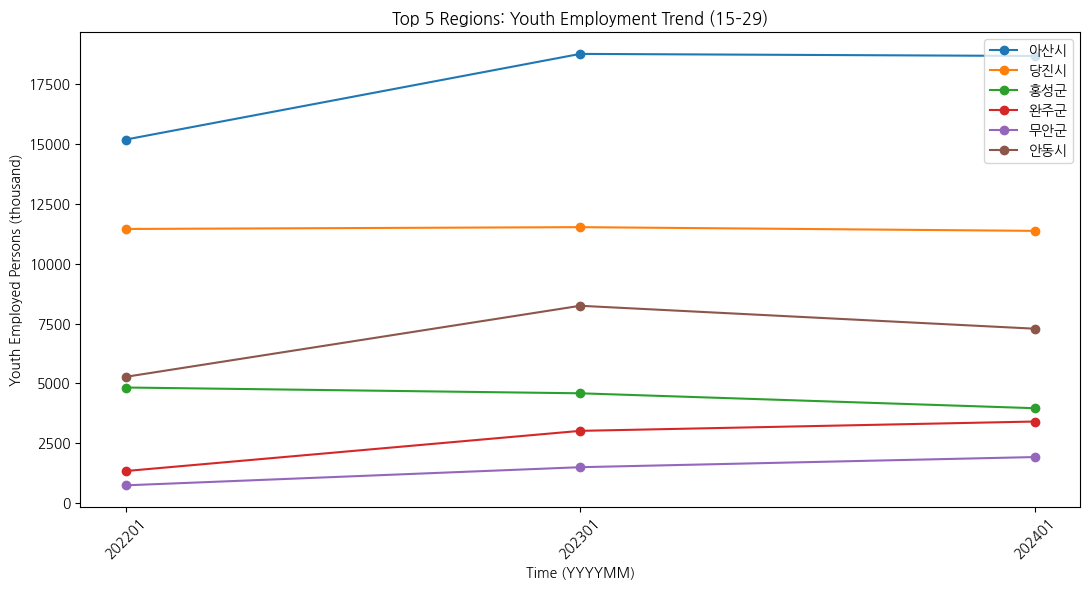

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# 기간 컬럼 자동 추출 (숫자형 YYYYMM)
pivot_df = pivot_df.loc[~(pivot_df['지역명'] == '아산시')].copy()

time_cols = sorted([c for c in diff.columns if str(c).isdigit()])

plt.figure(figsize=(11, 6))

for _, row in diff.iterrows():
    y = row[time_cols].astype(float).values
    plt.plot(time_cols, y, marker="o", label=row["시군구"])

plt.xlabel("Time (YYYYMM)")
plt.ylabel("Youth Employed Persons (thousand)")
plt.title("Top 5 Regions: Youth Employment Trend (15–29)")
plt.xticks(time_cols, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

